In [2]:
# !pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="rSXslHSkN3tTg49uOHSm")
project = rf.workspace("shivanshu-l2yyx").project("new_chichken_dataset-51hct")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import os, glob, math, random, sys
import yaml
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)


######## -------------- CONFIG / Auto-detect dataset folder --------------
######### If auto-detection fails, set DATASET_ROOT to the path where your extracted
###########Roboflow folder is located (for example: "./new_chichken_dataset-1")

In [5]:
candidates = [d for d in os.listdir('.') if d.startswith('new_chichken_dataset')]
if len(candidates) == 0:
    DATASET_DIR = "new_chichken_dataset-1"   
else:
    DATASET_DIR = candidates[0]

print("Using dataset dir:", DATASET_DIR)

# load class names from data.yaml
yaml_path = os.path.join(DATASET_DIR, "data.yaml")
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

CLASS_NAMES = data_yaml.get("names", [])
print("Classes found:", CLASS_NAMES)

Using dataset dir: new_chichken_dataset-1
Classes found: ['death_chicken', 'healthy_chicken']


In [6]:
# Cell 3 - helper utilities

IMG_EXTS = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

def find_image_for_label(lbl_path):
    """Given a path to a labels/.txt file returns the image path (searching images folders)."""
    base = os.path.splitext(os.path.basename(lbl_path))[0]
    # Search common images dirs first
    patterns = [os.path.join(DATASET_DIR, '**', 'images', base + ext) for ext in IMG_EXTS]
    for pat in patterns:
        matches = glob.glob(pat, recursive=True)
        if matches:
            return matches[0]
    # fallback: any file beginning with base
    for ext in IMG_EXTS:
        matches = glob.glob(os.path.join(DATASET_DIR, '**', base + '*' + ext), recursive=True)
        if matches:
            return matches[0]
    return None
from PIL import Image, ImageDraw, ImageFont

def draw_boxes_pil(img_path, annotations, class_map=None):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    
    try:
        font = ImageFont.truetype("arial.ttf", 14)  # Windows usually has Arial
    except:
        font = ImageFont.load_default()

    for ann in annotations:
        xmin, ymin, xmax, ymax = ann['xmin'], ann['ymin'], ann['xmax'], ann['ymax']
        cls = ann['class']
        label = class_map[cls] if class_map else str(cls)
        
        # Box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        
        # Text box (use textbbox instead of textsize)
        bbox = draw.textbbox((xmin, ymin), label, font=font)
        text_w = bbox[2] - bbox[0]
        text_h = bbox[3] - bbox[1]
        
        draw.rectangle([xmin, ymin - text_h, xmin + text_w, ymin], fill="red")
        draw.text((xmin, ymin - text_h), label, fill="white", font=font)

    return img


In [7]:
# Cell 4 - parse labels (.txt) -> annotations dataframe
rows = []
label_files = glob.glob(os.path.join(DATASET_DIR, "**", "labels", "*.txt"), recursive=True)
print("Label files found:", len(label_files))

for lbl in tqdm(label_files, desc="Parsing label files"):
    img_path = find_image_for_label(lbl)
    if img_path is None:
        # warning printed for debugging but not stopping
        print("WARNING: no image found for", lbl)
        continue
    try:
        iw, ih = Image.open(img_path).size
    except Exception as e:
        print("ERROR opening image", img_path, e)
        continue

    with open(lbl, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:5])
            x1 = max(0, (xc - w/2) * iw)
            y1 = max(0, (yc - h/2) * ih)
            x2 = min(iw, (xc + w/2) * iw)
            y2 = min(ih, (yc + h/2) * ih)
            rows.append({
                'image': os.path.basename(img_path),
                'img_path': img_path,
                'class': cls,
                'class_name': CLASS_NAMES[cls] if cls < len(CLASS_NAMES) else str(cls),
                'xc': xc, 'yc': yc, 'w': w, 'h': h,
                'xmin': x1, 'ymin': y1, 'xmax': x2, 'ymax': y2,
                'img_w': iw, 'img_h': ih
            })

df = pd.DataFrame(rows)
# derived fields
df['area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
df['area_norm'] = df['area'] / (df['img_w'] * df['img_h'])
df['aspect'] = (df['xmax'] - df['xmin']) / (df['ymax'] - df['ymin'] + 1e-9)

# save to CSV for easy reuse
df.to_csv("annotations_table.csv", index=False)
print("Annotations loaded:", len(df))
df.head()


Label files found: 697


Parsing label files: 100%|██████████| 697/697 [00:13<00:00, 49.91it/s]


Annotations loaded: 1139


image  \
0  001_438_IMG_gro401342-003-848x565_jpg.rf.599ca...   
1  001_438_IMG_gro401342-003-848x565_jpg.rf.599ca...   
2  001_438_IMG_gro401342-003-848x565_jpg.rf.599ca...   
3  001_438_IMG_gro401342-003-848x565_jpg.rf.599ca...   
4  001_438_IMG_gro401342-003-848x565_jpg.rf.599ca...   

                                            img_path  class       class_name  \
0  new_chichken_dataset-1\train\images\001_438_IM...      1  healthy_chicken   
1  new_chichken_dataset-1\train\images\001_438_IM...      1  healthy_chicken   
2  new_chichken_dataset-1\train\images\001_438_IM...      1  healthy_chicken   
3  new_chichken_dataset-1\train\images\001_438_IM...      1  healthy_chicken   
4  new_chichken_dataset-1\train\images\001_438_IM...      1  healthy_chicken   

         xc        yc         w         h     xmin     ymin     xmax     ymax  \
0  0.254151  0.185841  0.416840  0.353982   38.780    5.000  392.260  205.000   
1  0.417193  0.194690  0.211899  0.389381  263.935    0.000  443.625  220.000   
2  0.706026  0.228619  0.475106  0.351027  397.265   30.005  800.155  228.335   
3  0.265861  0.511805  0.498856  0.480832   13.935  153.335  436.965  425.005   
4  0.614222  0.798779  0.598090  0.402442  267.270  337.620  774.450  565.000   

   img_w  img_h         area  area_norm    aspect  
0    848    565   70696.0000   0.147554  1.767400  
1    848    565   39531.8000   0.082509  0.816773  
2    848    565   79905.1737   0.166775  2.031412  
3    848    565  114924.5601   0.239866  1.557147  
4    848    565  115322.5884   0.240697  2.230539

In [8]:
# Cell 5 - quick metrics
total_annotations = len(df)
unique_images = df['image'].nunique()
per_class_counts = df['class_name'].value_counts()

print("Total annotations:", total_annotations)
print("Unique images with labels:", unique_images)
print("\nAnnotations per class:\n", per_class_counts)

# images per split (if folder structure present)
train_imgs = glob.glob(os.path.join(DATASET_DIR, "train", "images", "*.*"))
valid_imgs = glob.glob(os.path.join(DATASET_DIR, "valid", "images", "*.*"))
test_imgs  = glob.glob(os.path.join(DATASET_DIR, "test", "images", "*.*"))
print("\nTrain images:", len(train_imgs), "Valid images:", len(valid_imgs), "Test images:", len(test_imgs))


Total annotations: 1139
Unique images with labels: 696

Annotations per class:
 class_name
healthy_chicken    791
death_chicken      348
Name: count, dtype: int64

Train images: 554 Valid images: 143 Test images: 0


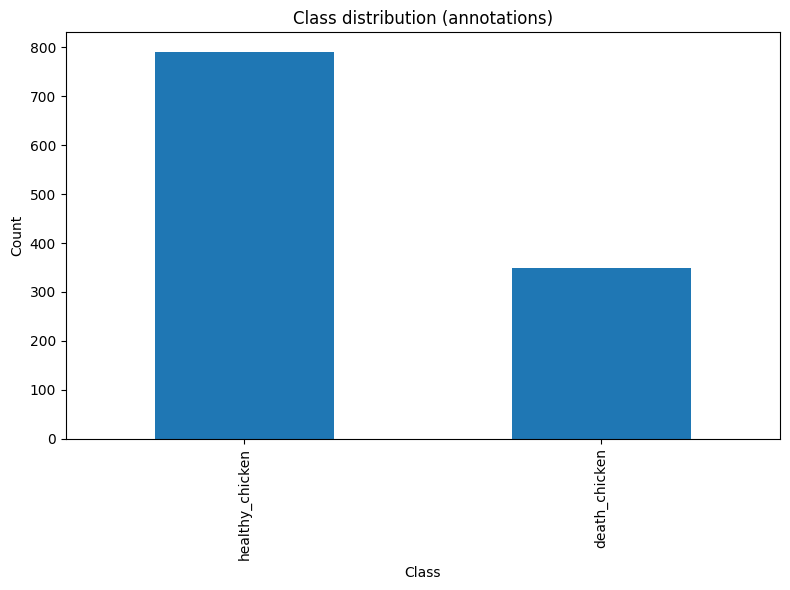

In [9]:
# Cell 6 - visualizations (each plot is its own figure)

# 1) Class distribution (bar)
plt.figure()
per_class_counts.plot(kind='bar')
plt.title('Class distribution (annotations)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


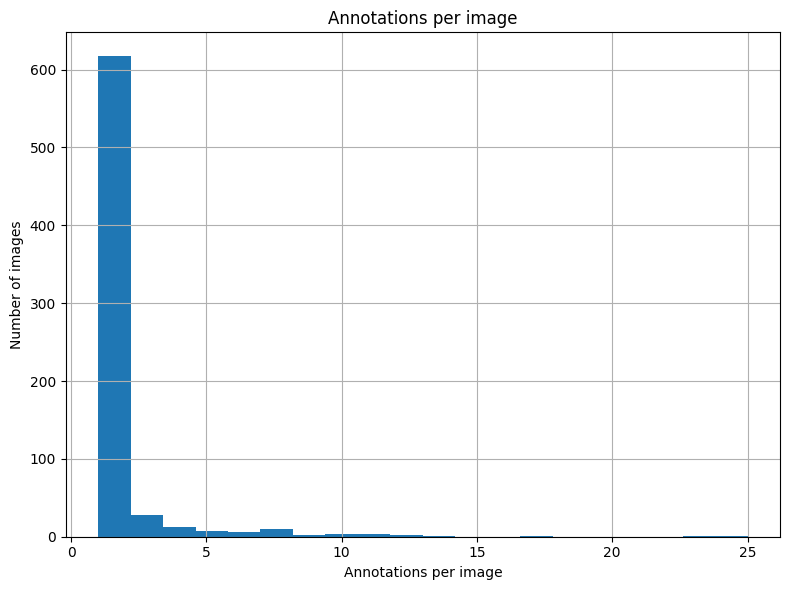

In [10]:

# 2) Annotations per image (histogram)
ann_per_img = df.groupby('image').size().rename('ann_count').reset_index()
plt.figure()
ann_per_img['ann_count'].hist(bins=20)
plt.title('Annotations per image')
plt.xlabel('Annotations per image')
plt.ylabel('Number of images')
plt.tight_layout()
plt.show()


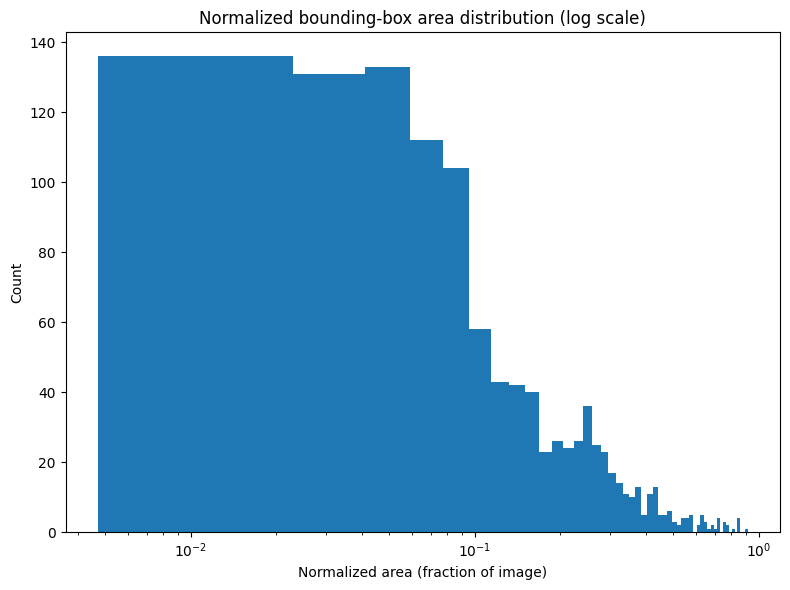

In [11]:

# 3) Normalized bbox area (log scale histogram)
plt.figure()
plt.hist(df['area_norm'], bins=50)
plt.xscale('log')
plt.title('Normalized bounding-box area distribution (log scale)')
plt.xlabel('Normalized area (fraction of image)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




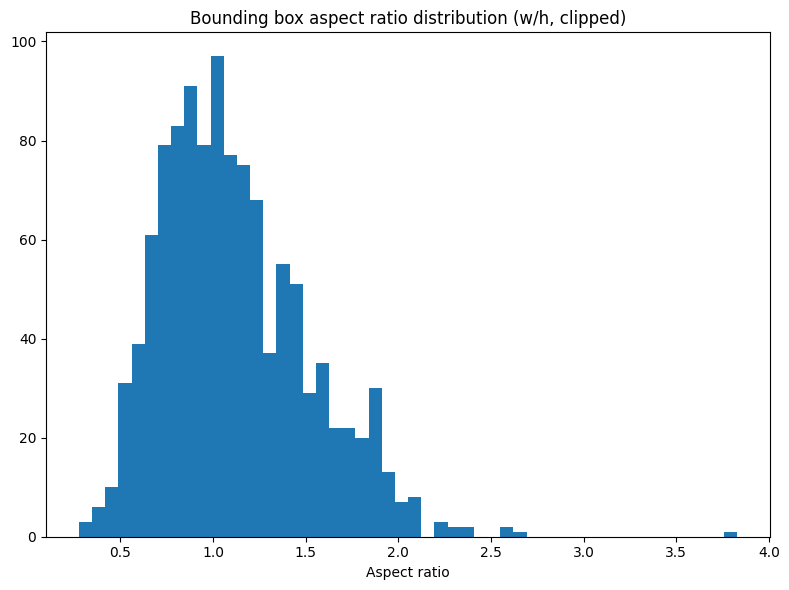

In [12]:
# 4) Aspect ratio histogram
plt.figure()
plt.hist(df['aspect'].clip(0.1, 10), bins=50)
plt.title('Bounding box aspect ratio distribution (w/h, clipped)')
plt.xlabel('Aspect ratio')
plt.tight_layout()
plt.show()



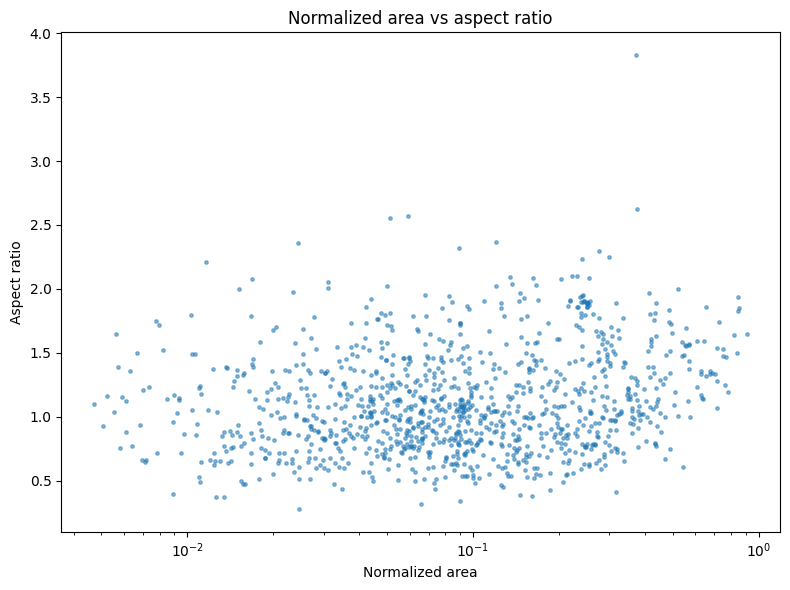

In [13]:
# 5) Area vs aspect scatter
plt.figure()
plt.scatter(df['area_norm'], df['aspect'], s=6, alpha=0.5)
plt.xscale('log')
plt.title('Normalized area vs aspect ratio')
plt.xlabel('Normalized area')
plt.ylabel('Aspect ratio')
plt.tight_layout()
plt.show()

##### show a sample of images with annotations (grid of images)

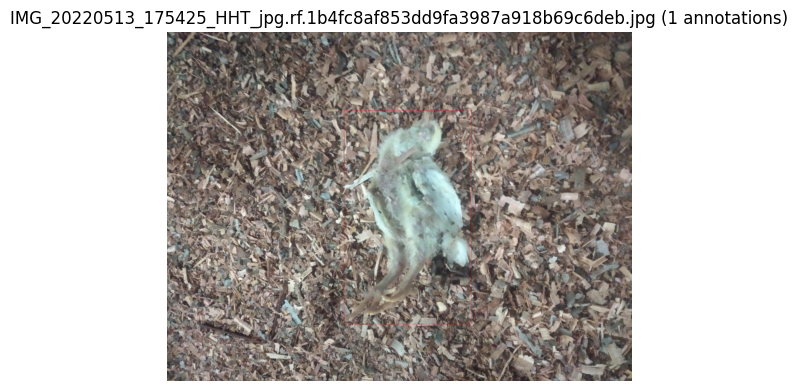

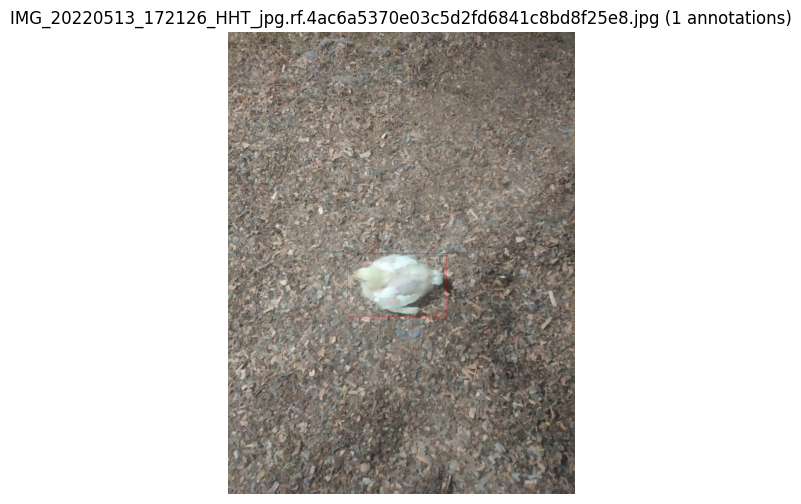

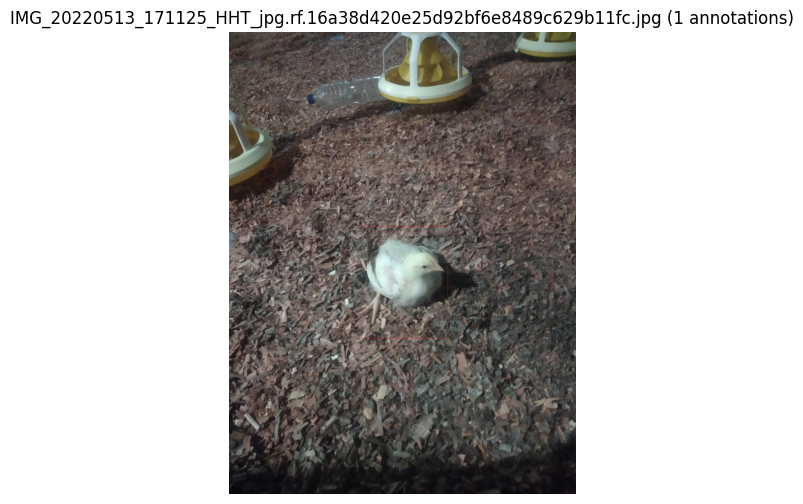

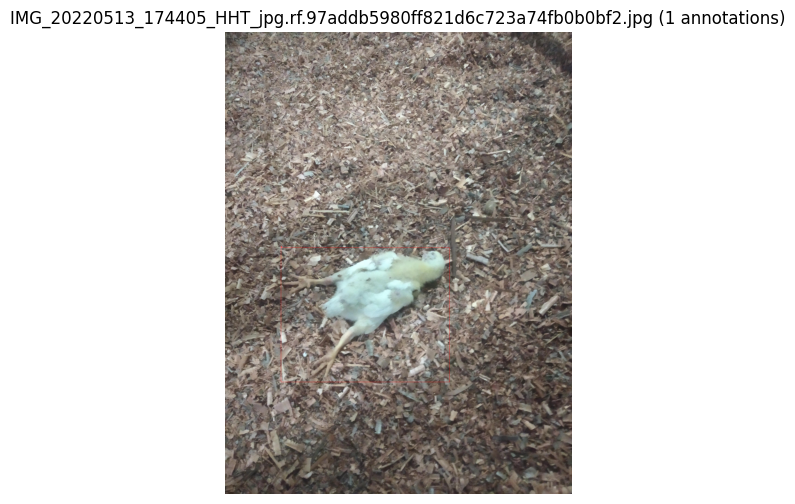

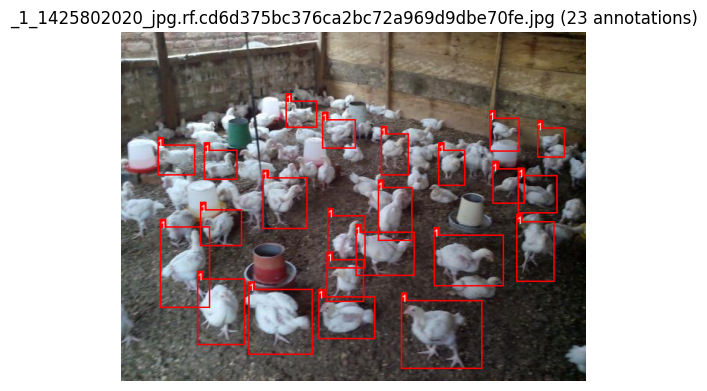

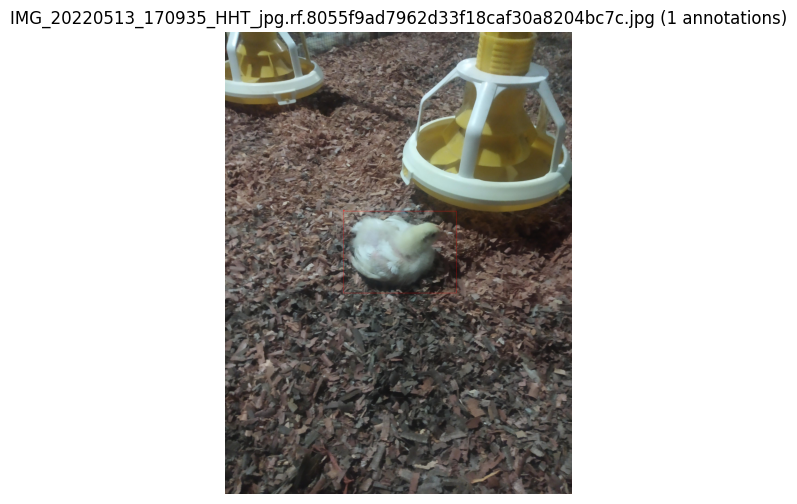

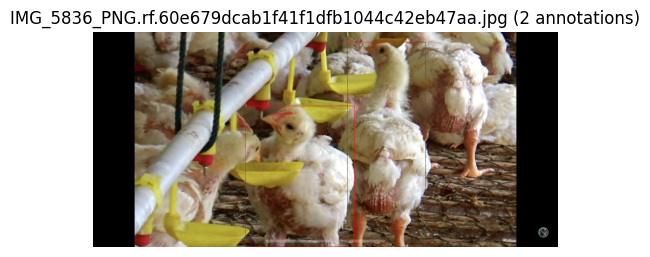

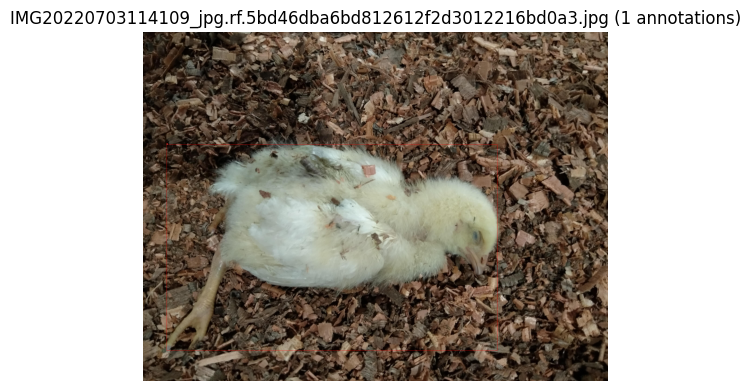

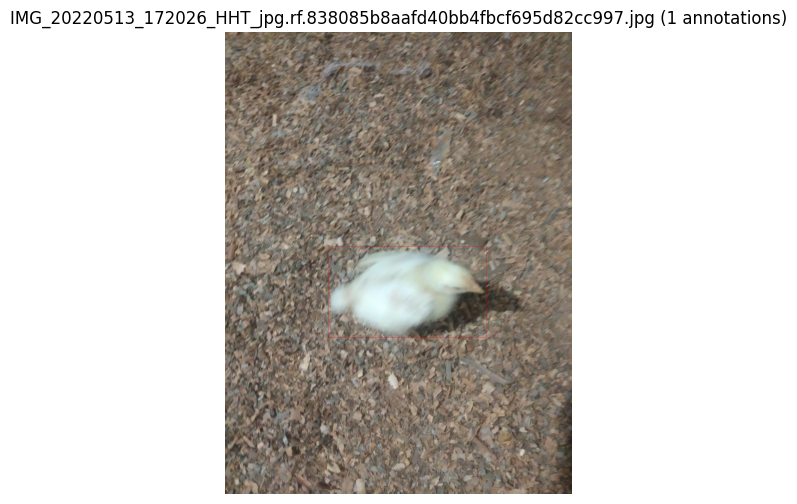

In [14]:
# Cell 7 - show sample images with bounding boxes
sample_images = df['image'].drop_duplicates().sample(
    n=min(9, df['image'].nunique()), random_state=42
).tolist()

for img_name in sample_images:
    sub = df[df['image'] == img_name].to_dict('records')
    
    if len(sub) == 0:
        print(f"⚠️ Skipping {img_name} (no annotations)")
        continue
    
    img_path = sub[0]['img_path']
    if not os.path.exists(img_path):
        print(f"⚠️ Missing file: {img_path}")
        continue
    
    try:
        img_with_boxes = draw_boxes_pil(img_path, sub)
        plt.figure(figsize=(6,6))
        plt.imshow(img_with_boxes)
        plt.title(f"{img_name} ({len(sub)} annotations)")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"⚠️ Could not draw {img_name}: {e}")


#### dataset QA checks (tiny boxes, boxes outside bounds, unlabeled images)

In [15]:

# automated QA checks

# 1) Boxes outside bounds (should be few because we clipped on load)
bad_bounds = df[(df['xmin'] < 0) | (df['ymin'] < 0) | (df['xmax'] > df['img_w']) | (df['ymax'] > df['img_h'])]
print("Boxes outside bounds (after clipping):", len(bad_bounds))


Boxes outside bounds (after clipping): 0


In [16]:

# 2) Tiny boxes (very small area fractions)
tiny_thresh = 0.001  # 0.1% of image
tiny_boxes = df[df['area_norm'] < tiny_thresh]
print("Tiny boxes (area < 0.1% of image):", len(tiny_boxes))




Tiny boxes (area < 0.1% of image): 0


In [17]:
# 3) Duplicate images check (same file hash)
import hashlib
def file_hash(path):
    h = hashlib.md5()
    with open(path,'rb') as f:
        h.update(f.read())
    return h.hexdigest()
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "images", "*.*"), recursive=True)
hashes = {}
duplicates = []
for p in image_paths:
    hb = file_hash(p)
    if hb in hashes:
        duplicates.append((p, hashes[hb]))
    else:
        hashes[hb] = p
print("Duplicate image pairs found:", len(duplicates))


Duplicate image pairs found: 0


In [18]:

# 4) Images with no labels
all_images = glob.glob(os.path.join(DATASET_DIR, "**", "images", "*.*"), recursive=True)
basename_to_path = {os.path.basename(p): p for p in all_images}
labeled_basenames = set(df['image'].unique())
unlabeled = [p for b,p in basename_to_path.items() if b not in labeled_basenames]
print("Images with no labels (example 10):", len(unlabeled))
unlabeled[:10]

Images with no labels (example 10): 1


['new_chichken_dataset-1\\train\\images\\IMG20220703113754_jpg.rf.153e214b2a2d88765cf34849232958fd.jpg']

In [19]:
# Extract unlabeled images for review
import shutil

# create folder if it doesn't exist
output_folder = "unlabeled_images"
os.makedirs(output_folder, exist_ok=True)

# copy unlabeled images to the folder
for img_path in unlabeled:
    try:
        shutil.copy(img_path, output_folder)
    except Exception as e:
        print(f"Error copying {img_path}: {e}")

# save CSV for reference
unlabeled_df = pd.DataFrame({"image_path": unlabeled})
unlabeled_df.to_csv("unlabeled_images.csv", index=False)

print(f"Copied {len(unlabeled)} unlabeled images to '{output_folder}'")
print("CSV saved as 'unlabeled_images.csv' for review")


Copied 1 unlabeled images to 'unlabeled_images'
CSV saved as 'unlabeled_images.csv' for review


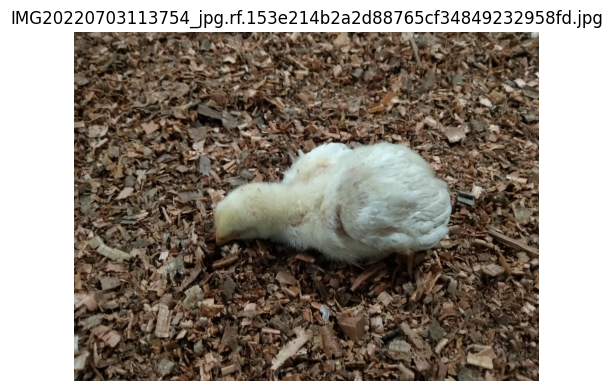

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

for img_path in unlabeled[:5]:  # preview first 5
    img = Image.open(img_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(img_path.split("\\")[-1])
    plt.axis('off')
    plt.show()


In [21]:
# !pip install ultralytics


In [ ]:
import os

# change path to your dataset root
dataset_path = r"H:\Requin\10 sep\new_chichken_dataset-1"

splits = ["train", "valid", "test"]

for split in splits:
    img_dir = os.path.join(dataset_path, split, "images")
    lbl_dir = os.path.join(dataset_path, split, "labels")

    n_imgs = len(os.listdir(img_dir)) if os.path.exists(img_dir) else 0
    n_lbls = len(os.listdir(lbl_dir)) if os.path.exists(lbl_dir) else 0

    print(f"{split.upper()} → Images: {n_imgs}, Labels: {n_lbls}")


TRAIN → Images: 554, Labels: 554
VALID → Images: 143, Labels: 143
TEST → Images: 0, Labels: 0


# Load YOLOv8 model

In [ ]:
# ==============================
# Mortality Monitoring - YOLOv8
# ==============================

from ultralytics import YOLO

# ------------------------------
# 1. Load Base Model
# ------------------------------
# Using YOLOv8 small model (yolov8s.pt) for small dataset
model = YOLO("yolov8s.pt")

# ------------------------------
# 2. Hyperparameter Tuning
# ------------------------------
# This step will try different learning rates, augmentations, etc.

tune_results = model.tune(
    data=r"H:\Requin\10 sep\new_chichken_dataset-1\data.yaml",
    epochs=20,           # short run just for tuning
    imgsz=512,           # good size for chicken dataset
    optimizer="AdamW",   # stable optimizer
    device="cpu",        # use CPU
    plots=True           # save training plots
)

print("✅ Best hyperparameters found:", tune_results)

# ------------------------------
# 3. Train Final Model
# ------------------------------
# Now train with tuned params for longer epochs
model.train(
    data=r"H:\Requin\10 sep\new_chichken_dataset-1\data.yaml",
    epochs=100,          # upper limit
    imgsz=512,
    batch=4,             # safe for CPU/RAM
    patience=10,         # early stop if no improvement
    optimizer="AdamW",  # Adamw optimizer from tuning  by this  we can get better result.   
    device="cpu",
    workers=2,         # number of data loader workers it can tell  us how many cpu we have .
    augment=True         # enable data augmentation ,augmentation tell us to create a new training samples .
)

# ------------------------------
# 4. Evaluate Accuracy
# ------------------------------
metrics = model.val()
print("📊 Model Accuracy:", metrics.box.map50 * 100, "% (mAP@0.5)")


Tuner: Initialized Tuner instance with 'tune_dir=C:\Users\SHIVANSHU SRIVASTAVA\runs\detect\tune3'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0, 'close_mosaic': 10}
Saved C:\Users\SHIVANSHU SRIVASTAVA\runs\detect\tune3\tune_scatter_plots.png
Saved C:\Users\SHIVANSHU SRIVASTAVA\runs\detect\tune3\tune_fitness.png

Tuner: 1/10 iterations complete  (10093.44s)
Tuner: Results saved to C:\Users\SHIVANSHU SRIVASTAVA\runs\detect\tune3
Tuner: Best fitness=0.64367 observed at iteration 1
Tuner: Best fitness metrics are {'metric

Running inference on: H:\Requin\10 sep\new_chichken_dataset-1\valid\images

image 1/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\001_22_IMG_Copyof2nd14220136402_AGRIPHOTO_TIMSCRIVENER-scaled_jpg.rf.47fba50a2cefe8d218643d8730346957.jpg: 352x512 5 healthy_chickens, 164.8ms
image 2/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\1533098087717_jpg.rf.421d5d8c889224cb5e32ea2842f456ee.jpg: 288x512 1 death_chicken, 3 healthy_chickens, 142.9ms
image 3/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\1fdqwpge7k75_jpg.rf.77250893c40d9a528b6cfb1cc8b269b5.jpg: 352x512 5 healthy_chickens, 151.4ms
image 4/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\93292270_MTEyNS0xNTAwLTA1NzM1ZTk3YzQ_jpg.rf.2893fc6e3a79066b321a9e14066a7cf7.jpg: 512x384 10 healthy_chickens, 192.0ms
image 5/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\Broiler-benefits_embedded-1-_jpg.rf.02e055c987a3edca21afbb05f618c2fa.jpg: 384x512 10 healthy_chickens, 164.1ms
image 6/143 H:\Requi

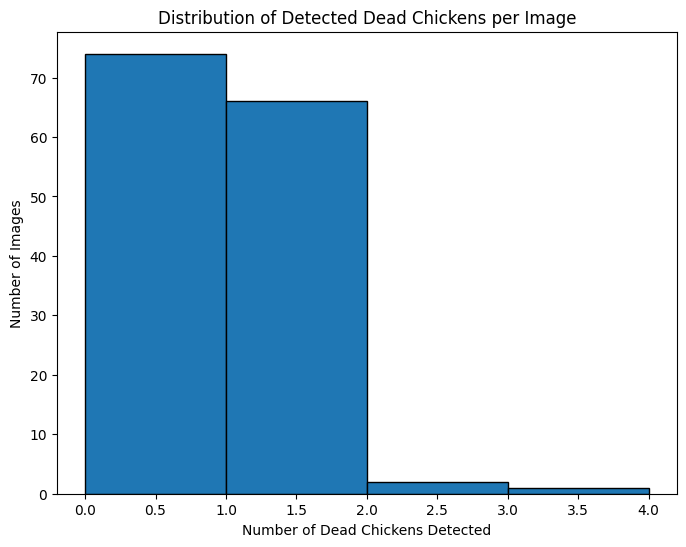

In [29]:
import os
import cv2
import pandas as pd
from matplotlib import pyplot as plt

# -------------------------
# Step 1: Run YOLOv8 predictions on valid set
test_images_path = r"H:\Requin\10 sep\new_chichken_dataset-1\valid\images"

print("Running inference on:", test_images_path)
results = model.predict(source=test_images_path, save=True, conf=0.3)

# -------------------------
# Step 2: Count detected 'death_chicken' per image
death_counts = []

for result in results:
    boxes = result.boxes
    labels = result.boxes.cls  # numeric labels
    names = [model.names[int(i)] for i in labels]
    death_count = names.count('death_chicken')
    death_counts.append({
        'image': os.path.basename(result.path),  # ✅ fixed here
        'death_count': death_count
    })

# -------------------------
# Step 3: Create DataFrame
death_counts_df = pd.DataFrame(death_counts)

print("✅ Detected death_chicken counts per image:")
print(death_counts_df.head(10))  # show first 10 rows

# -------------------------
# Step 4 (Optional): Save results for later analysis
output_csv = r"H:\Requin\10 sep\death_chicken_counts.csv"
death_counts_df.to_csv(output_csv, index=False)
print(f"\nResults saved to: {output_csv}")

# -------------------------
# Step 5: Simple visualization - histogram
plt.figure(figsize=(8,6))
plt.hist(
    death_counts_df['death_count'],
    bins=range(0, death_counts_df['death_count'].max()+2),
    edgecolor='black'
)
plt.xlabel("Number of Dead Chickens Detected")
plt.ylabel("Number of Images")
plt.title("Distribution of Detected Dead Chickens per Image")
plt.show()


####### DBSCAN clustering per-image (detect mortality hotspots) & visualization

In [30]:
import pandas as pd

# Load detection results
df = pd.read_csv("detections.csv")  

# Check available columns
print(df.columns)
print(df.head())


Index(['timestamp', 'frame_id', 'label', 'x1', 'y1', 'x2', 'y2', 'image_file'], dtype='object')
             timestamp  frame_id          label  x1   y1   x2   y2  \
0  2025-10-01 17:44:49       281  death_chicken   2  140  490  698   
1  2025-10-01 17:44:50       284  death_chicken   0   45  351  574   

                                image_file  
0  saved_frames\frame281_death_chicken.jpg  
1  saved_frames\frame284_death_chicken.jpg  


✅ Data loaded. Columns: ['timestamp', 'image', 'class_name', 'x1', 'y1', 'x2', 'y2', 'img_path']
             timestamp  image     class_name  x1   y1   x2   y2  \
0  2025-10-01 17:44:49    281  death_chicken   2  140  490  698   
1  2025-10-01 17:44:50    284  death_chicken   0   45  351  574   

                                  img_path  
0  saved_frames\frame281_death_chicken.jpg  
1  saved_frames\frame284_death_chicken.jpg  
Images containing death-class: 2


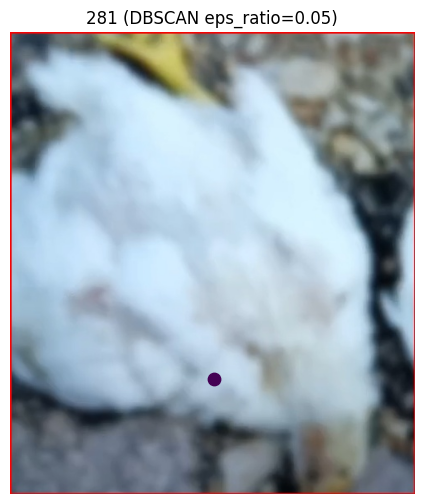

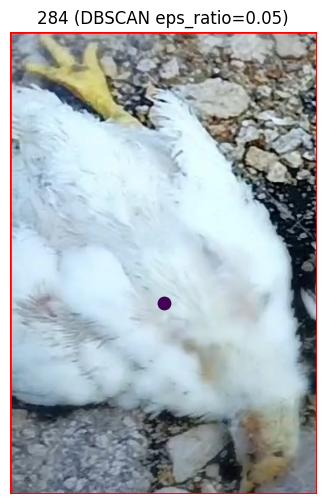

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from PIL import Image
import math

# ------------------------
# Load detections CSV
# ------------------------
df = pd.read_csv("detections.csv")

# Make sure expected columns exist
# Adjust these renames based on your actual CSV
if "label" in df.columns and "class_name" not in df.columns:
    df.rename(columns={"label": "class_name"}, inplace=True)
if "image_file" in df.columns and "img_path" not in df.columns:
    df.rename(columns={"image_file": "img_path"}, inplace=True)
if "frame_id" in df.columns and "image" not in df.columns:
    df.rename(columns={"frame_id": "image"}, inplace=True)

print("✅ Data loaded. Columns:", df.columns.tolist())
print(df.head())

# Class names (adapt this if needed)
CLASS_NAMES = ["death_chicken", "healthy_chicken"]

# ------------------------
# Clustering function
# ------------------------
def cluster_image(df_image, eps_ratio=0.05, min_samples=2):
    """
    Perform DBSCAN clustering on bounding box centers.
    Adds 'cluster' column to the dataframe.
    """
    if df_image.empty:
        return df_image

    # Get image dimensions from first image
    img_path = df_image['img_path'].iloc[0]
    img = Image.open(img_path)
    iw, ih = img.size
    diag = math.hypot(iw, ih)
    eps = eps_ratio * diag  # eps in pixels

    # Compute centers
    centers = np.vstack([
        ((df_image['x1'] + df_image['x2']) / 2).values,
        ((df_image['y1'] + df_image['y2']) / 2).values
    ]).T

    if len(centers) < 2:
        df_image = df_image.copy()
        df_image['cluster'] = -1
        return df_image

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(centers)
    df_image = df_image.copy()
    df_image['cluster'] = clustering.labels_
    return df_image

# ------------------------
# Run clustering on images with death_chicken
# ------------------------
if 'class_name' in df.columns:
    if 'death_chicken' in CLASS_NAMES:
        death_df = df[df['class_name'] == 'death_chicken']
    else:
        death_df = df[df['class_name'].str.contains('death', case=False)]
    images_with_death = death_df['image'].unique().tolist()
    print("Images containing death-class:", len(images_with_death))
else:
    print("Column 'class_name' not found in DataFrame. Skipping clustering.")
    death_df = pd.DataFrame()
    images_with_death = []

# ------------------------
# Plot a few clustered images
# ------------------------
for img_name in images_with_death[:6]:
    sub_all = df[df['image'] == img_name]
    clustered = cluster_image(sub_all, eps_ratio=0.05, min_samples=2)
    if 'cluster' not in clustered:
        continue

    # plot image
    img_path = clustered['img_path'].iloc[0]
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(8,6))
    plt.imshow(img)

    # centers colored by cluster id
    centers = np.vstack([
        ((clustered['x1']+clustered['x2'])/2).values,
        ((clustered['y1']+clustered['y2'])/2).values
    ]).T
    labels = clustered['cluster'].values
    plt.scatter(centers[:,0], centers[:,1], c=labels, s=80)

    # annotate cluster centroids (skip noise = -1)
    for lab in set(labels):
        if lab == -1: 
            continue
        pts = centers[labels == lab]
        cx, cy = pts.mean(axis=0)
        plt.text(cx, cy, f"Cluster {lab}", fontsize=12, weight='bold')

    plt.title(f"{img_name} (DBSCAN eps_ratio=0.05)")
    plt.axis('off')
    plt.show()


Images containing death-class: 2


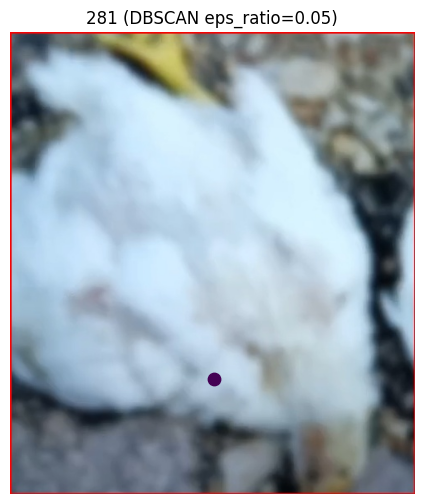

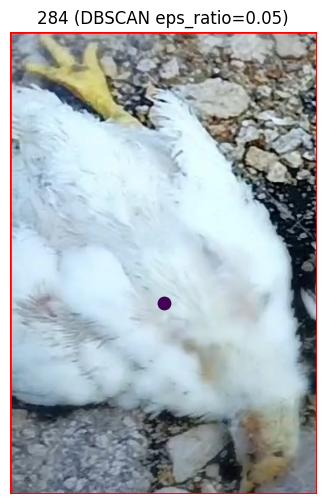

In [33]:
#clustering (DBSCAN) to find local hotspots inside an image
def cluster_image(df_image, eps_ratio=0.05, min_samples=2):
    """
    Perform DBSCAN clustering on bounding box centers.
    Adds 'cluster' column to the dataframe.
    """
    if df_image.empty:
        return df_image

    # Get image dimensions from first image
    img_path = df_image['img_path'].iloc[0]
    img = Image.open(img_path)
    iw, ih = img.size
    diag = math.hypot(iw, ih)
    eps = eps_ratio * diag  # eps in pixels

    # Compute centers
    centers = np.vstack([
        ((df_image['x1'] + df_image['x2']) / 2).values,
        ((df_image['y1'] + df_image['y2']) / 2).values
    ]).T

    if len(centers) < 2:
        df_image = df_image.copy()
        df_image['cluster'] = -1
        return df_image

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(centers)
    df_image = df_image.copy()
    df_image['cluster'] = clustering.labels_
    return df_image

# Run clustering on a few images containing death_chicken
if 'class_name' in df.columns:
    if 'death_chicken' in CLASS_NAMES:
        death_df = df[df['class_name'] == 'death_chicken']
    else:
        death_df = df[df['class_name'].str.contains('death', case=False)]
    images_with_death = death_df['image'].unique().tolist()
    print("Images containing death-class:", len(images_with_death))
else:
    print("Column 'class_name' not found in DataFrame. Skipping clustering.")
    death_df = pd.DataFrame()
    images_with_death = []

for img_name in images_with_death[:6]:
    sub_all = df[df['image'] == img_name]
    clustered = cluster_image(sub_all, eps_ratio=0.05, min_samples=2)
    if 'cluster' not in clustered:
        continue
    # plot image
    img_path = clustered['img_path'].iloc[0]
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    # centers colored by cluster id
    centers = np.vstack([ ((clustered['x1']+clustered['x2'])/2).values, ((clustered['y1']+clustered['y2'])/2).values ]).T
    labels = clustered['cluster'].values
    plt.scatter(centers[:,0], centers[:,1], c=labels, s=80)
    # annotate cluster centroids (skip noise = -1)
    for lab in set(labels):
        if lab == -1: continue
        pts = centers[labels == lab]
        cx, cy = pts.mean(axis=0)
        plt.text(cx, cy, f"Cluster {lab}", fontsize=12, weight='bold')
    plt.title(f"{img_name} (DBSCAN eps_ratio=0.05)")
    plt.axis('off')
    plt.show()


# heatmap overlay for density of dead birds (per-image)

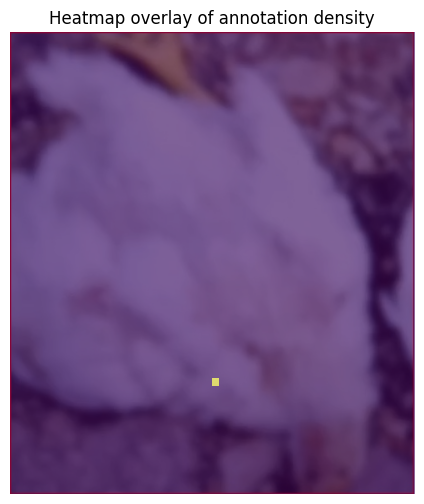

In [35]:
#  - heatmap overlay of bbox centers on top of image
def heatmap_for_image(df_image, bins=(64,64)):
    if df_image.empty:
        print("No annotations for this image.")
        return
    img_path = df_image['img_path'].iloc[0]
    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    # Use correct columns for bbox centers
    if {'xmin', 'xmax', 'ymin', 'ymax'}.issubset(df_image.columns):
        centers_x = ((df_image['xmin'] + df_image['xmax']) / 2).values
        centers_y = ((df_image['ymin'] + df_image['ymax']) / 2).values
    elif {'x1', 'x2', 'y1', 'y2'}.issubset(df_image.columns):
        centers_x = ((df_image['x1'] + df_image['x2']) / 2).values
        centers_y = ((df_image['y1'] + df_image['y2']) / 2).values
    else:
        print("No valid bbox columns found in DataFrame.")
        return

    if len(centers_x) == 0:
        print("No centers")
        return
    H, xedges, yedges = np.histogram2d(centers_x, centers_y, bins=bins, range=[[0, w], [0, h]])
    H = np.rot90(H)
    H = np.flipud(H)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    # overlay heatmap (default colormap)
    plt.imshow(H, alpha=0.6, extent=(0, w, h, 0))
    plt.title("Heatmap overlay of annotation density")
    plt.axis('off')
    plt.show()

# show heatmap for first image with death annotation
if len(images_with_death) > 0:
    heatmap_for_image(df[df['image'] == images_with_death[0]], bins=(64,64))
else:
    print("No death images found in dataset for heatmap.")


In [36]:
# Fix: Use 'class_name' if present, else fallback to 'label'
if 'class_name' in df.columns:
	print(df['class_name'].value_counts())
elif 'label' in df.columns:
	print(df['label'].value_counts())
else:
	print("Neither 'class_name' nor 'label' column found in DataFrame.")


class_name
death_chicken    2
Name: count, dtype: int64


# flagged images & save a summary CSV

In [37]:
# Cell 11 - save summary & flagged examples
from PIL import Image
import os

# Compute area and normalized area for each bounding box
def compute_area_norm(row):
    img_path = row['img_path']
    if not os.path.exists(img_path):
        return None
    try:
        with Image.open(img_path) as img:
            iw, ih = img.size
    except Exception:
        return None
    area = max(0, (row['x2'] - row['x1'])) * max(0, (row['y2'] - row['y1']))
    area_norm = area / (iw * ih) if iw > 0 and ih > 0 else None
    return area_norm

df['area_norm'] = df.apply(compute_area_norm, axis=1)

# unlabeled
# Save flagged items for review
tiny_boxes = df[df['area_norm'] < 0.001]
tiny_sample = tiny_boxes[['image','img_path','class_name','area_norm']].head(200)
tiny_sample.to_csv("flagged_tiny_boxes.csv", index=False)
df.to_csv("annotations_full.csv", index=False)
# Create a summary dictionary
summary = {
    "Total annotations": len(df),
    "Unique images": df['image'].nunique(),
    "Classes": ", ".join(CLASS_NAMES),
    "Annotations per class": df['class_name'].value_counts().to_dict()
}

# simple text file summary
with open("dataset_summary.txt","w") as f:
    for k,v in summary.items():
        f.write(f"{k}: {v}\n")
print("Saved: flagged_tiny_boxes.csv, annotations_full.csv, dataset_summary.txt")


Saved: flagged_tiny_boxes.csv, annotations_full.csv, dataset_summary.txt


# Stacked Bar Chart per Image (healthy vs death)

<Figure size 1200x600 with 0 Axes>

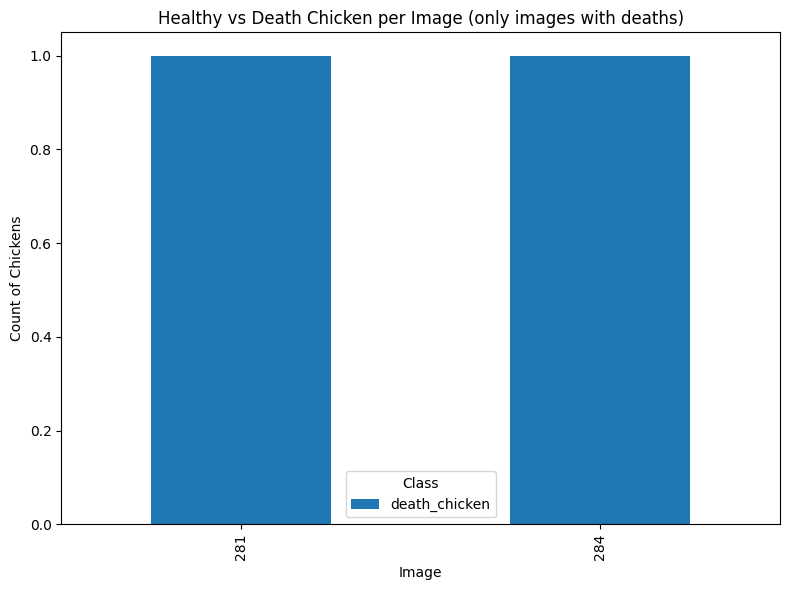

In [41]:
# Stacked bar chart: healthy vs death per image
# Group by image and class
img_class_counts = df.groupby(['image','class_name']).size().unstack(fill_value=0)

# Only show images with at least 1 death_chicken
if 'death_chicken' not in img_class_counts.columns:
	img_class_counts['death_chicken'] = 0
img_class_counts_filtered = img_class_counts[img_class_counts['death_chicken'] > 0]

if img_class_counts_filtered.empty:
	print("No images with death_chicken found. Nothing to plot.")
else:
	plt.figure(figsize=(12,6))
	img_class_counts_filtered.plot(kind='bar', stacked=True)
	plt.title("Healthy vs Death Chicken per Image (only images with deaths)")
	plt.xlabel("Image")
	plt.ylabel("Count of Chickens")
	plt.legend(title="Class")
	plt.tight_layout()
	plt.show()


# Time-series style plot (image sequence)

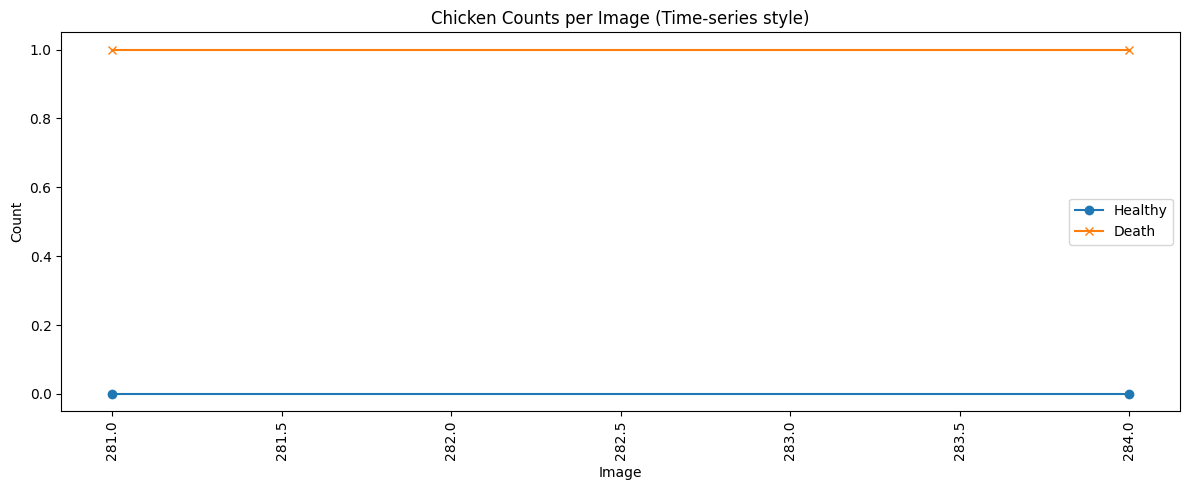

In [42]:
# Create a "time" index based on image name sorting
df_sorted = df.sort_values('image')  # change to timestamp if available
time_series_counts = df_sorted.groupby('image')['class_name'].value_counts().unstack(fill_value=0)

# Ensure both columns exist
for cname in CLASS_NAMES:
	if cname not in time_series_counts.columns:
		time_series_counts[cname] = 0

plt.figure(figsize=(12,5))
plt.plot(time_series_counts.index, time_series_counts['healthy_chicken'], label='Healthy', marker='o')
plt.plot(time_series_counts.index, time_series_counts['death_chicken'], label='Death', marker='x')
plt.xticks(rotation=90)
plt.title("Chicken Counts per Image (Time-series style)")
plt.xlabel("Image")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


# Cluster Heatmap Overlay for Multiple Images


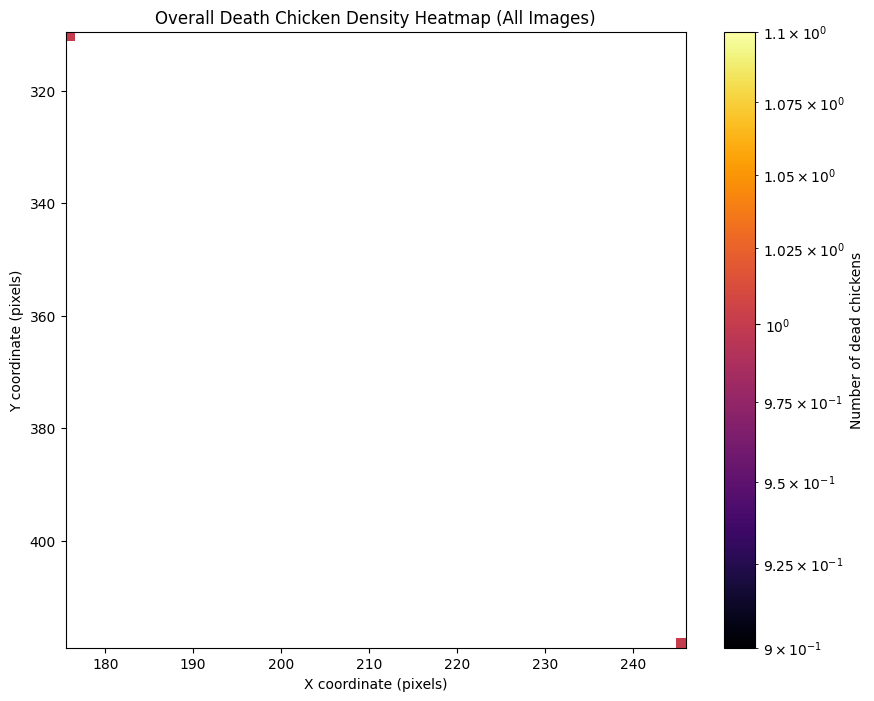

In [45]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Heatmap overlay for multiple images
death_df = df[df['class_name']=='death_chicken']

# Collect all bbox centers across all images
all_centers_x, all_centers_y = [], []

for img_name in death_df['image'].unique():
    sub = death_df[death_df['image']==img_name]
    centers_x = ((sub['x1'] + sub['x2'])/2).values
    centers_y = ((sub['y1'] + sub['y2'])/2).values
    all_centers_x.extend(centers_x)
    all_centers_y.extend(centers_y)

if len(all_centers_x) > 0 and len(all_centers_y) > 0:
    plt.figure(figsize=(10,8))
    # create 2D histogram (heatmap)
    h = plt.hist2d(all_centers_x, all_centers_y, bins=(64,64), norm=LogNorm(), cmap='inferno')
    plt.colorbar(label='Number of dead chickens')
    plt.title("Overall Death Chicken Density Heatmap (All Images)")
    plt.xlabel("X coordinate (pixels)")
    plt.ylabel("Y coordinate (pixels)")
    plt.gca().invert_yaxis()  # match image coordinates
    plt.show()
else:
    print("No dead chicken detections found in the dataset. Heatmap cannot be plotted.")


In [46]:
import os

# check what files exist in the training weights folder
weights_path = r"H:\Requin\10 sep\runs\detect\train\weights"
if os.path.exists(weights_path):
	print("Files in weights folder:", os.listdir(weights_path))
else:
	print(f"Folder does not exist: {weights_path}")


Folder does not exist: H:\Requin\10 sep\runs\detect\train\weights


In [47]:
from ultralytics import YOLO

# Load your trained model
model = YOLO(r"H:\Requin\10 sep\detect\train4\weights\best.pt")

# Validate model on validation set
metrics = model.val()

# Extract values using correct attributes
precision = metrics.box.mp * 100      # mean precision %
recall = metrics.box.mr * 100         # mean recall %
map50 = metrics.box.map50 * 100       # mAP@0.5 %
map5095 = metrics.box.map * 100       # mAP@[0.5:0.95]

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"mAP@50: {map50:.2f}%")
print(f"mAP@50-95: {map5095:.2f}%")


Ultralytics 8.3.202  Python-3.11.13 torch-2.8.0+cpu CPU (AMD Ryzen 7 7435HS)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.40.1 ms, read: 131.575.3 MB/s, size: 1174.8 KB)
val: Scanning H:\Requin\19 sep\new_chichken_dataset-1\valid\labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 143/143 143.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.6it/s 15.1s1.9s
                   all        143        198      0.749      0.484      0.655      0.442
         death_chicken         65         65      0.918      0.516      0.791      0.568
       healthy_chicken         80        133      0.581      0.451      0.518      0.317
Speed: 0.9ms preprocess, 49.7ms inference, 0.0ms loss, 9.6ms postprocess per image
Results saved to C:\Users\SHIVANSHU SRIVASTAVA\runs\detect\val13
Precision: 74.94%
Recall: 48.38%
mAP@50: 65.49%
mAP@50-95: 44

In [48]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [49]:
results = model.predict(r"H:\Requin\10 sep\new_chichken_dataset-1\valid\images", save=True)



image 1/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\001_22_IMG_Copyof2nd14220136402_AGRIPHOTO_TIMSCRIVENER-scaled_jpg.rf.47fba50a2cefe8d218643d8730346957.jpg: 448x640 (no detections), 74.2ms
image 2/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\1533098087717_jpg.rf.421d5d8c889224cb5e32ea2842f456ee.jpg: 384x640 (no detections), 69.2ms
image 3/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\1fdqwpge7k75_jpg.rf.77250893c40d9a528b6cfb1cc8b269b5.jpg: 416x640 (no detections), 60.3ms
image 4/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\93292270_MTEyNS0xNTAwLTA1NzM1ZTk3YzQ_jpg.rf.2893fc6e3a79066b321a9e14066a7cf7.jpg: 640x480 (no detections), 66.4ms
image 5/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\Broiler-benefits_embedded-1-_jpg.rf.02e055c987a3edca21afbb05f618c2fa.jpg: 448x640 3 healthy_chickens, 46.3ms
image 6/143 H:\Requin\10 sep\new_chichken_dataset-1\valid\images\Broilers-c-TimScriv-1422013-6400-2_jpg.rf.19412cba68b53cde1d5cd2fb

In [50]:
metrics = model.val()  # Evaluate performance on validation set
print(metrics)


Ultralytics 8.3.202  Python-3.11.13 torch-2.8.0+cpu CPU (AMD Ryzen 7 7435HS)
val: Fast image access  (ping: 0.30.1 ms, read: 504.3111.3 MB/s, size: 1177.4 KB)
val: Scanning H:\Requin\19 sep\new_chichken_dataset-1\valid\labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 143/143 143.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.6it/s 14.7s1.8s
                   all        143        198      0.749      0.484      0.655      0.442
         death_chicken         65         65      0.918      0.516      0.791      0.568
       healthy_chicken         80        133      0.581      0.451      0.518      0.317
Speed: 1.0ms preprocess, 52.3ms inference, 0.0ms loss, 10.0ms postprocess per image
Results saved to C:\Users\SHIVANSHU SRIVASTAVA\runs\detect\val14
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
co

In [51]:
from ultralytics import YOLO
model = YOLO("H:/Requin/10 sep/detect/train4/weights/best.pt")
print(model.names)


{0: 'death_chicken', 1: 'healthy_chicken'}


In [52]:
from ultralytics import YOLO

# Load your model
model = YOLO(r"H:/Requin/10 sep/detect/train4/weights/best.pt")


# Print model info
print(model)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [53]:
import cv2
from ultralytics import YOLO
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Load YOLOv8 model
model = YOLO(r"H:\Requin\10 sep\detect\train4\weights\best.pt")

# Open webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # YOLO prediction
        results = model.predict(frame, conf=0.3)

        # Counters
        death_count = 0
        healthy_count = 0

        # Draw boxes
        for r in results:
            boxes = r.boxes.xyxy.cpu().numpy()
            labels = [model.names[int(i)] for i in r.boxes.cls]
            for (x1, y1, x2, y2), label in zip(boxes, labels):
                if label == "death_chicken":
                    color = (255,0,0)  # Blue for matplotlib
                    death_count += 1
                else:
                    color = (0,255,0)
                    healthy_count += 1

                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color[::-1], 2)
                cv2.putText(frame, label, (int(x1), int(y1)-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, color[::-1], 2)

        # Display counts & alert
        cv2.putText(frame, f"Death: {death_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.putText(frame, f"Healthy: {healthy_count}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        if death_count > 0:
            cv2.putText(frame, "ALERT! Dead chicken detected!", (10, 110),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 3)

        # Convert BGR to RGB for Jupyter
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display in notebook
        plt.figure(figsize=(8,6))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()
        clear_output(wait=True)

except KeyboardInterrupt:
    print("Stopped by user")

finally:
    cap.release()


0: 384x640 (no detections), 41.1ms
Stopped by user


In [54]:
from ultralytics import YOLO

# Load your trained model (correct path)
model = YOLO(r"H:/Requin/10 sep/detect/train4/weights/best.pt")

# Evaluate on validation dataset
metrics = model.val(data=r"H:\Requin\10 sep\new_chichken_dataset-1\data.yaml")


Ultralytics 8.3.202  Python-3.11.13 torch-2.8.0+cpu CPU (AMD Ryzen 7 7435HS)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 780.0277.9 MB/s, size: 973.9 KB)
val: Scanning H:\Requin\10 sep\new_chichken_dataset-1\valid\labels.cache... 143 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 143/143  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.7it/s 13.2s1.6s
                   all        143        198      0.749      0.484      0.655      0.442
         death_chicken         65         65      0.918      0.516      0.791      0.568
       healthy_chicken         80        133      0.581      0.451      0.518      0.317
Speed: 0.9ms preprocess, 46.6ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to C:\Users\SHIVANSHU SRIVASTAVA\runs\detect\val15


In [55]:
import os, pandas as pd
print("mortality_log1.csv exists:", os.path.exists("mortality_log.csv"))
print(pd.read_csv("mortality_log1.csv").tail())
print("detections.csv exists:", os.path.exists("detections.csv"))
if os.path.exists("detections1.csv"):
    print(pd.read_csv("detections1.csv").head())
print("saved_frames:", os.listdir("saved_frames")[:10])


mortality_log.csv exists: True
             timestamp  death_count  healthy_count
0  2025-10-01 17:44:49            1              0
1  2025-10-01 17:44:50            1              0
detections.csv exists: True
             timestamp  frame_id          label  x1   y1   x2   y2  \
0  2025-10-01 17:44:49       281  death_chicken   2  140  490  698   
1  2025-10-01 17:44:50       284  death_chicken   0   45  351  574   

                                image_file  
0  saved_frames\frame281_death_chicken.jpg  
1  saved_frames\frame284_death_chicken.jpg  
saved_frames: ['frame281_death_chicken.jpg', 'frame284_death_chicken.jpg']


In [56]:
import pandas as pd
df = pd.read_csv("detections1.csv")
print(df.head())


             timestamp  frame_id          label  x1   y1   x2   y2  \
0  2025-10-01 17:44:49       281  death_chicken   2  140  490  698   
1  2025-10-01 17:44:50       284  death_chicken   0   45  351  574   

                                image_file  
0  saved_frames\frame281_death_chicken.jpg  
1  saved_frames\frame284_death_chicken.jpg  


In [9]:
import pandas as pd

# Load the dataframe if not already loaded
df = pd.read_csv("detections1.csv")

# outlier removal based on bbox area
area_thresh = 0.001  # 0.1% of image area

# Compute image width and height for each row
def get_img_size(img_path):
	try:
		with Image.open(img_path) as img:
			return img.size  # (width, height)
	except Exception:
		return (None, None)

df['img_w'], df['img_h'] = zip(*df['image_file'].apply(get_img_size))

# Remove rows where image size could not be determined
df = df.dropna(subset=['img_w', 'img_h'])

df['area_norm'] = (df['x2'] - df['x1']) * (df['y2'] - df['y1']) / (df['img_w'] * df['img_h'])
print("Before filtering:", len(df))
df = df[df['area_norm'] >= area_thresh]
print("After filtering:", len(df))

# Use 'label' column for class counts (your dataframe uses 'label', not 'class_name')
print(df['label'].value_counts())





Before filtering: 36
After filtering: 36
label
healthy_chicken    33
death_chicken       3
Name: count, dtype: int64


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Example: Replace these with your actual results
# y_true = ground truth labels (0 = healthy, 1 = deceased)
# y_pred = model predictions (0 or 1)
y_true = [0, 0, 1, 1, 0, 1, 0, 1, 1, 0]   
y_pred = [0, 1, 1, 1, 0, 0, 0, 1, 1, 0]   

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
 [[4 1]
 [1 4]]
Accuracy: 0.8000
Precision: 0.8000
Recall: 0.8000
F1 Score: 0.8000
